In [87]:
def imgs_to_array(cond, path):
    imgs = []
    valid_images = [".jpg",".png"]
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        x = Image.open(os.path.join(path,f))
        y = x.resize((100, 100))
        p = np.array(y)
        p = p.astype('float32')
        p = p/255.0
        imgs.append(p)
        #imgs.append(Image.open(os.path.join(path,f)))
    numb = len(imgs)
    if cond == 'clean':
        lbl = np.zeros(numb)
    elif cond == 'polluted':
        lbl = np.ones(numb)
    return (imgs, lbl)

In [90]:
from PIL import Image
import os, os.path
import numpy as np
from numpy import asarray

#Create a train data and label
data = []
lbl = []

#Create permanent arrays to save img arrays
data_clean = []
data_polluted = []
#Create permanent arrays to save lbl arrays
lbl_clean = []
lbl_polluted = []

path_clean = "/Users/Davran/0_Deep_Learning_Project/Insulator/ML/Clean"
path_polluted = "/Users/Davran/0_Deep_Learning_Project/Insulator/ML/Polluted"
cond_1 = 'clean'
cond_2 = 'polluted'

(data, lbl_clean) = imgs_to_array(cond_1, path_clean)
(data_polluted, lbl_polluted) = imgs_to_array(cond_2, path_polluted)

data.extend(data_polluted)
lbl = np.concatenate((lbl_clean,lbl_polluted))

In [92]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras import regularizers
import tensorflow as tf

data = np.array(data)
lbl = np.array(lbl)
shuffled_idx = np.random.permutation(6)
data[:] = data[shuffled_idx]
lbl[:] = lbl[shuffled_idx]
print(data.shape)
print(lbl.shape)

(6, 100, 100, 3)
(6,)


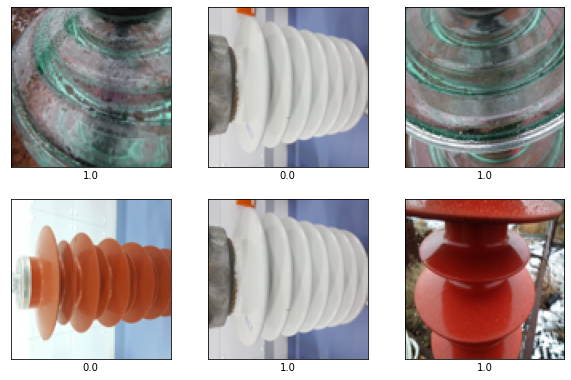

In [94]:
from tensorflow.keras.constraints import MaxNorm
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.constraints import MaxNorm
plt.figure(figsize = (10, 10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i], cmap = plt.cm.binary)
    plt.xlabel(lbl[i])

In [82]:
def define_model(dropout_rate=0.2, neurons=1, kernel_size = 3, learning_rate = 0.001):   
    model = models.Sequential()
    
    for i in range(neurons):
        n = 2*(i+2)
        model.add(layers.Conv2D(n, (kernel_size, kernel_size), activation = 'relu', input_shape = (100, 100, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
    

    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))    
        
    # compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate),
                  metrics=['acc'])
    return model

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=define_model, 
                        verbose=1)

dropout_rate = [ 0.2, 0.5]
neurons = [1, 2, 3, 4]
kernel_size = [3, 5]
learning_rate =  [0.001, 0.0001]
batch_size = [4, 8, 16, 32]
epochs = [150]

param_grid = dict(dropout_rate=dropout_rate, neurons = neurons, kernel_size = kernel_size, learning_rate = learning_rate,
                  batch_size=batch_size,
                  epochs=epochs)


In [ ]:
from sklearn.model_selection import GridSearchCV
from tune_sklearn import TuneSearchCV

grid = TuneSearchCV(estimator=model, param_distributions=param_grid, early_stopping=False, cv=5,  use_gpu =True)

grid_result = grid.fit(data, lbl)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))